In [1]:
!pip install yfinance
!pip install ffn
!pip install pykalman

[*********************100%***********************]  2 of 2 completed


Ticker            ADBE       MSFT
Date                             
2018-03-01  210.320007  93.989998
2018-03-02  203.960007  91.580002
2018-03-05  208.750000  92.339996
2018-03-06  212.440002  94.339996
2018-03-07  211.330002  93.160004


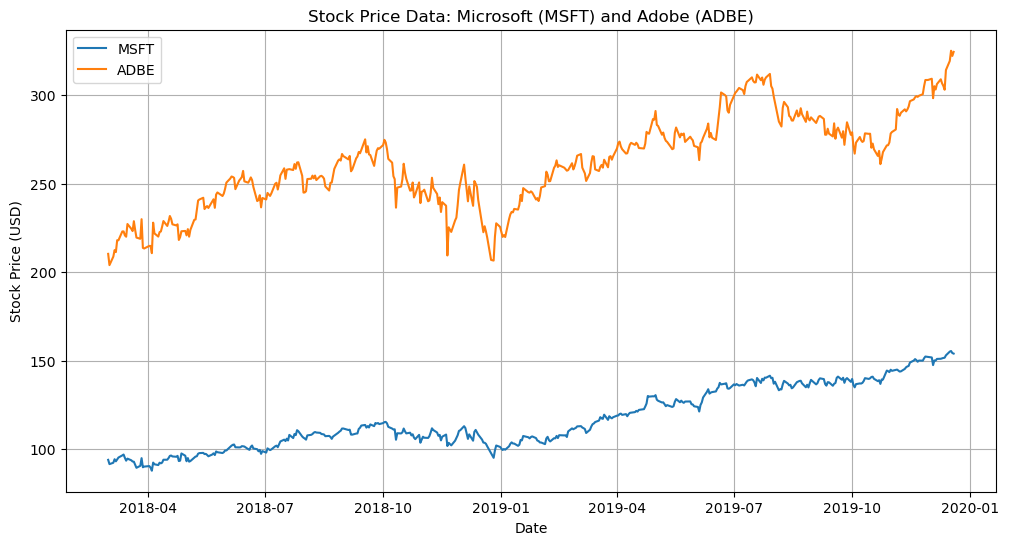

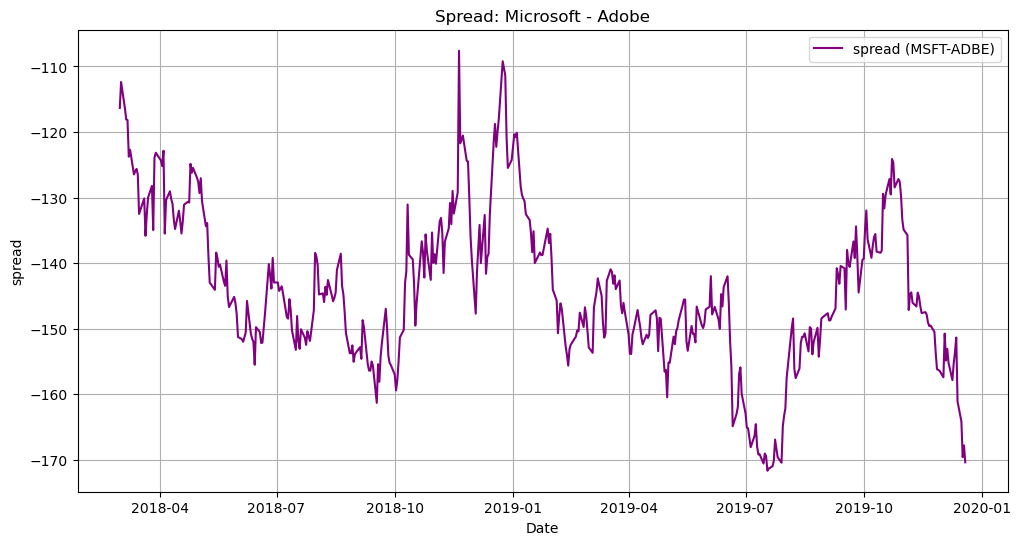

In [157]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
tickers = ['MSFT', 'ADBE']

data = yf.download(tickers, start="2018-03-01", end="2019-12-20")['Open']
print(data.head())
data['spread'] = data['MSFT'] - data['ADBE']
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)

plt.title("Stock Price Data: Microsoft (MSFT) and Adobe (ADBE)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['spread'], label='spread (MSFT-ADBE)', color='purple')
plt.title("Spread: Microsoft - Adobe")
plt.xlabel("Date")
plt.ylabel("spread")
plt.legend()
plt.grid(True)
plt.show()


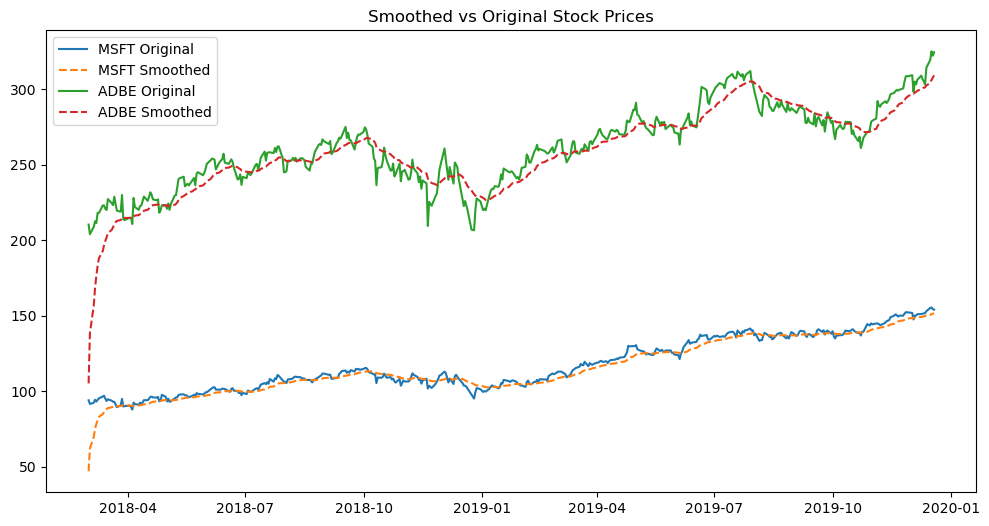

In [158]:
from pykalman import KalmanFilter
def KalmanFilterAverage(x):
    # Construct a Kalman filter for smoothing
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    
    state_means, _ = kf.filter(x.values)
    return pd.Series(state_means.flatten(), index=x.index)

# Apply smoothing
data['MSFT_smoothed'] = KalmanFilterAverage(data['MSFT'])
data['ADBE_smoothed'] = KalmanFilterAverage(data['ADBE'])

# Plot the smoothed series
plt.figure(figsize=(12, 6))
plt.plot(data['MSFT'], label='MSFT Original')
plt.plot(data['MSFT_smoothed'], label='MSFT Smoothed', linestyle='--')
plt.plot(data['ADBE'], label='ADBE Original')
plt.plot(data['ADBE_smoothed'], label='ADBE Smoothed', linestyle='--')
plt.legend()
plt.title("Smoothed vs Original Stock Prices")
plt.show()


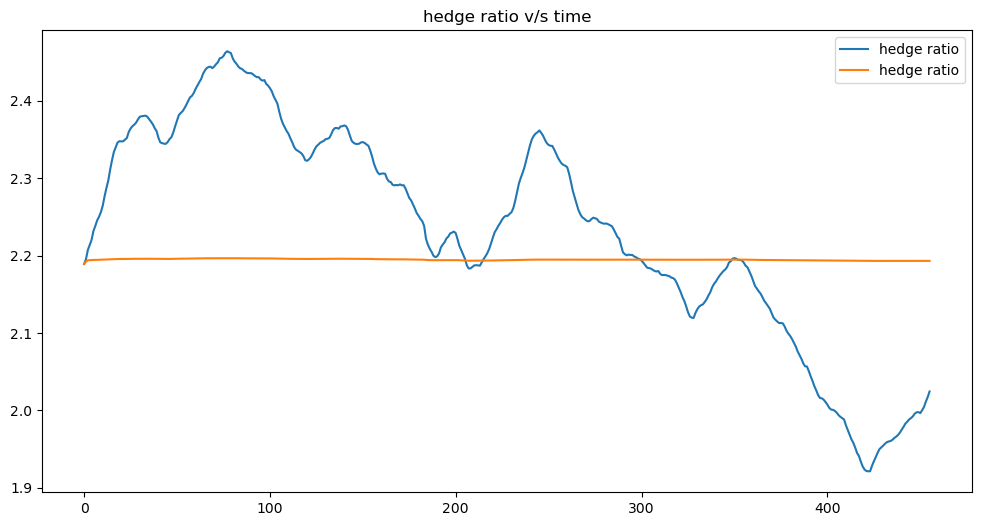

In [159]:
import numpy as np
def KalmanFilterRegression(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance
    obs_mat = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    
    state_means, _ = kf.filter(y.values)
    return state_means

# Calculate hedge ratio dynamically
hedge_ratios = KalmanFilterRegression(data['MSFT_smoothed'], data['ADBE_smoothed'])
data['hedge_ratio'] = hedge_ratios[:, 0]

# Calculate the spread
data['spread'] = data['ADBE_smoothed'] - data['hedge_ratio'] * data['MSFT_smoothed']

plt.figure(figsize=(12, 6))
plt.plot(hedge_ratios, label='hedge ratio', linestyle='-')
plt.legend()
plt.title("hedge ratio v/s time")
plt.show()

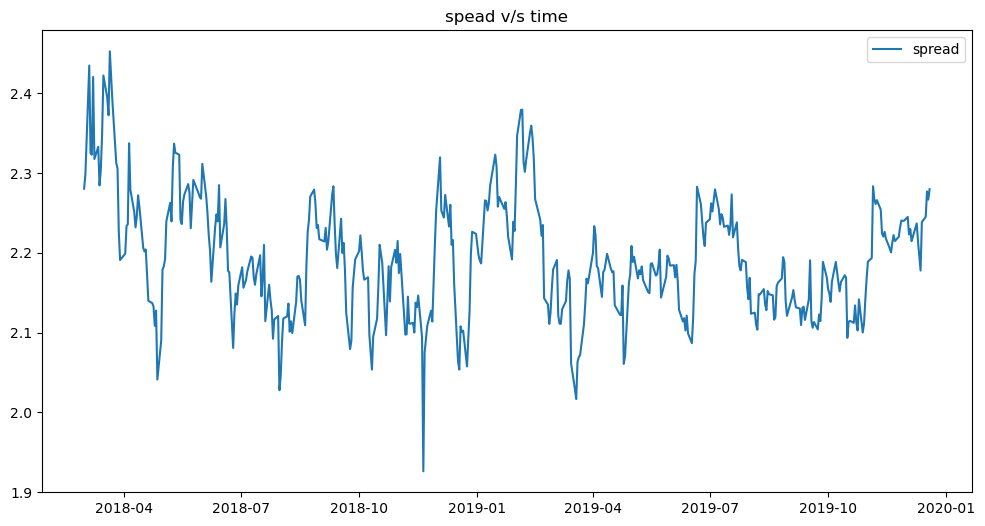

Hurst Exponent of the Spread: 0.2753785411194489


In [160]:
def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(ts.diff(lag).dropna()) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]

# Calculate Hurst exponent for the spread
hurst = hurst_exponent(data['spread'])
plt.figure(figsize=(12, 6))
plt.plot(data['spread'], label='spread', linestyle='-')
plt.legend()
plt.title("spead v/s time")
plt.show()
print(f"Hurst Exponent of the Spread: {hurst}")

C:\Users\shubh\AppData\Local\Temp\ipykernel_25688\2087010545.py:53: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['num units long'][0] = 0
C:\Users\shubh\AppData\Local\Temp\ipykernel_25688\2087010545.py:53: SettingWithCopyWarning: 
A val

Sharpe Ratio: 0.9374516572218602
Total PnL: 141.77742633837033


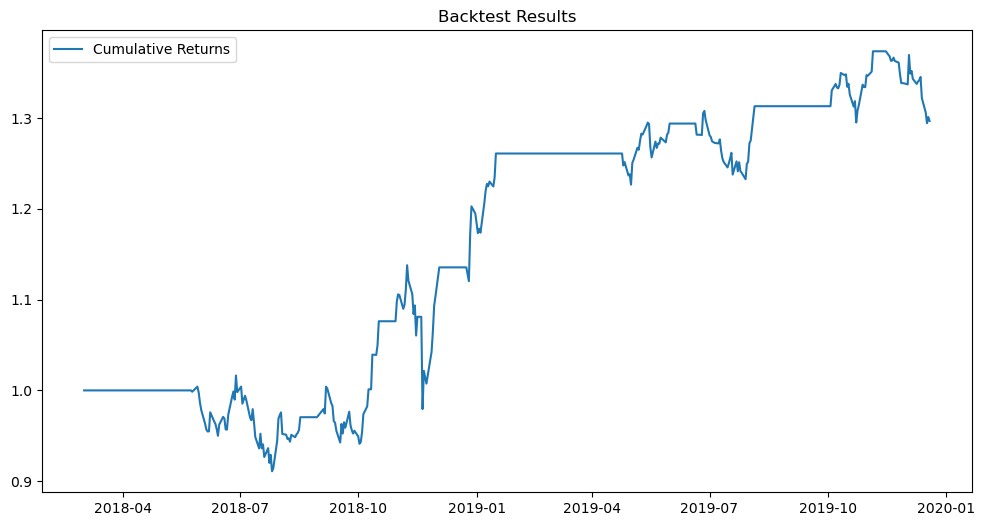

In [161]:
def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(x.values)
    return pd.Series(state_means.flatten(), index=x.index)

# Define Kalman Filter Regression
def KalmanFilterRegression(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    state_means, _ = kf.filter(y.values)
    return state_means

# Define Half-Life Function
def half_life(series):
    lagged = series.shift(1).dropna()
    delta = series.diff().dropna()
    beta = np.polyfit(lagged, delta, 1)[0]
    halflife = -np.log(2) / beta
    return int(max(halflife, 1))

# Define Backtest Function
def backtest(s1, s2, x, y):
    df1 = pd.DataFrame({'y': y, 'x': x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1['hr'] = -state_means[:, 0]
    df1['spread'] = df1.y - (df1.x * df1.hr)
    
    halflife = half_life(df1['spread'])
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread - meanSpread) / stdSpread
    
    entryZscore = 2
    exitZscore = 0
    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > -exitZscore) & (df1.zScore.shift(1) < -exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'], 'num units long'] = 1
    df1.loc[df1['long exit'], 'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'], 'num units short'] = -1
    df1.loc[df1['short exit'], 'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum() + 1

    # Calculate PnL
    df1['PnL'] = df1['port rets'] * ((df1['x'] * abs(df1['hr'])) + df1['y'])
    total_pnl = df1['PnL'].sum()

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe, df1['PnL'], total_pnl

# Perform Backtest
cumulative_returns, sharpe_ratio, pnl_per_trade, total_pnl = backtest('MSFT', 'ADBE', data['MSFT'], data['ADBE'])
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Total PnL: {total_pnl}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title("Backtest Results")
plt.legend()
plt.show()

C:\Users\shubh\AppData\Local\Temp\ipykernel_25688\2437538886.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['num units long'][0] = 0
C:\Users\shubh\AppData\Local\Temp\ipykernel_25688\2437538886.py:54: SettingWithCopyWarning: 
A val

Sharpe Ratio: 0.9374516572218602
CAGR: 15.52%
Maximum Drawdown: -13.93%
Calmar Ratio: 1.11
Sortino Ratio: 0.93
Daily Sharpe Ratio: 0.06


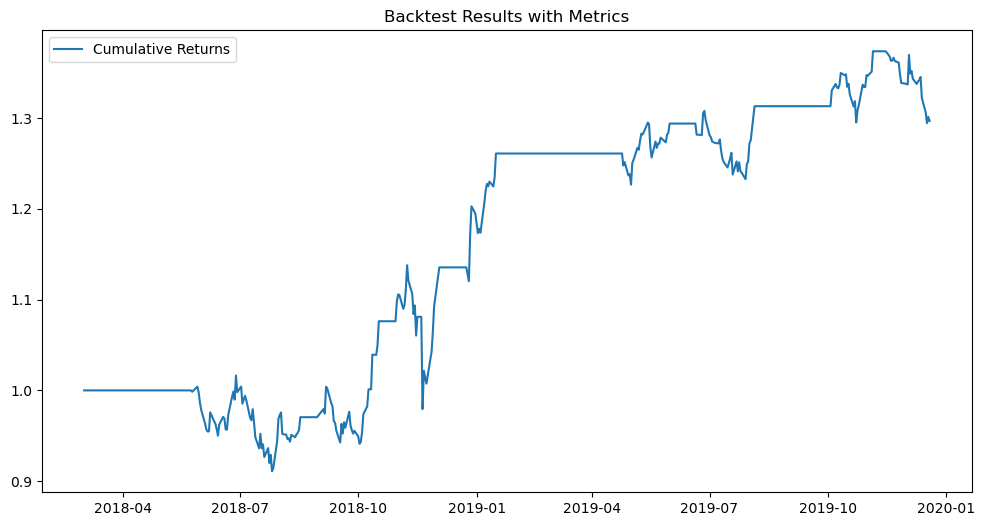

In [162]:
# Define Kalman Filter Average
def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(x.values)
    return pd.Series(state_means.flatten(), index=x.index)

# Define Kalman Filter Regression
def KalmanFilterRegression(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    state_means, _ = kf.filter(y.values)
    return state_means

# Define Half-Life Function
def half_life(series):
    lagged = series.shift(1).dropna()
    delta = series.diff().dropna()
    beta = np.polyfit(lagged, delta, 1)[0]
    halflife = -np.log(2) / beta
    return int(max(halflife, 1))

# Define Backtest Function
def backtest(s1, s2, x, y):
    df1 = pd.DataFrame({'y': y, 'x': x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1['hr'] = -state_means[:, 0]
    df1['spread'] = df1.y - (df1.x * df1.hr)
    
    halflife = half_life(df1['spread'])
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread - meanSpread) / stdSpread
    
    entryZscore = 2
    exitZscore = 0
    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > -exitZscore) & (df1.zScore.shift(1) < -exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'], 'num units long'] = 1
    df1.loc[df1['long exit'], 'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'], 'num units short'] = -1
    df1.loc[df1['short exit'], 'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum() + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1, sharpe

# Perform Backtest
df, sharpe_ratio = backtest('MSFT', 'ADBE', data['MSFT'], data['ADBE'])

# Calculate Metrics
start_date = df.index[0]
end_date = df.index[-1]
years = (end_date - start_date).days / 365.25

# CAGR
cagr = (df['cum rets'].iloc[-1] ** (1 / years)) - 1

# Maximum Drawdown
rolling_max = df['cum rets'].cummax()
drawdown = df['cum rets'] / rolling_max - 1
max_drawdown = drawdown.min()

# Calmar Ratio
calmar_ratio = -cagr / max_drawdown if max_drawdown < 0 else 0.0

# Sortino Ratio
downside_std = df.loc[df['port rets'] < 0, 'port rets'].std()
sortino_ratio = (df['port rets'].mean() / downside_std) * sqrt(252)

# Daily Sharpe Ratio
daily_sharpe = df['port rets'].mean() / df['port rets'].std()

# Display Metrics
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"CAGR: {cagr:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Daily Sharpe Ratio: {daily_sharpe:.2f}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df['cum rets'], label='Cumulative Returns')
plt.title("Backtest Results with Metrics")
plt.legend()
plt.show()

[*********************100%***********************]  2 of 2 completed
C:\Users\shubh\AppData\Local\Temp\ipykernel_25688\2850744872.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['num units long'][0] = 0
C:\Users\shubh\AppData\Local\

Out-of-Sample Sharpe Ratio: 0.24708234726129527
Out-of-Sample CAGR: 4.53%
Out-of-Sample Maximum Drawdown: -21.77%
Out-of-Sample Calmar Ratio: 0.21
Out-of-Sample Sortino Ratio: 0.30
Out-of-Sample Daily Sharpe Ratio: 0.02
Out-of-Sample PnL: 0.09


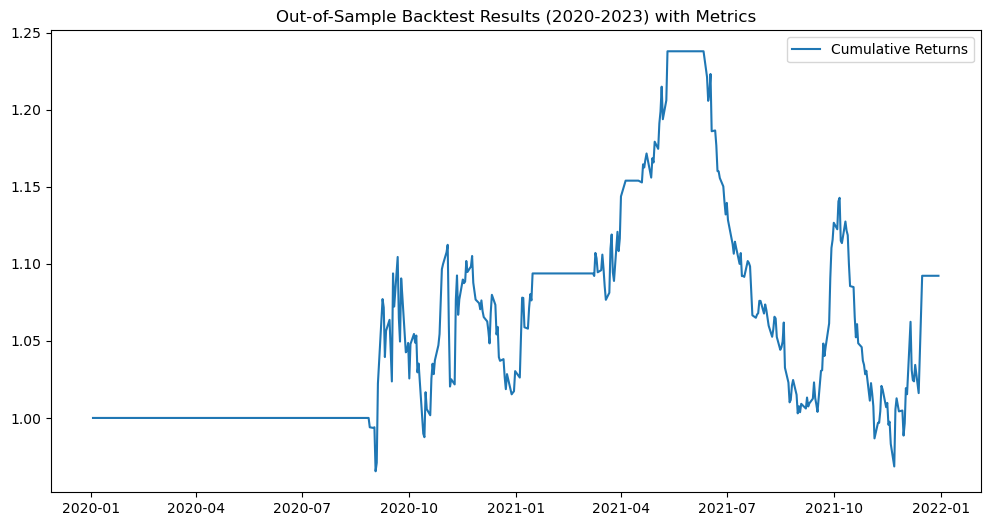

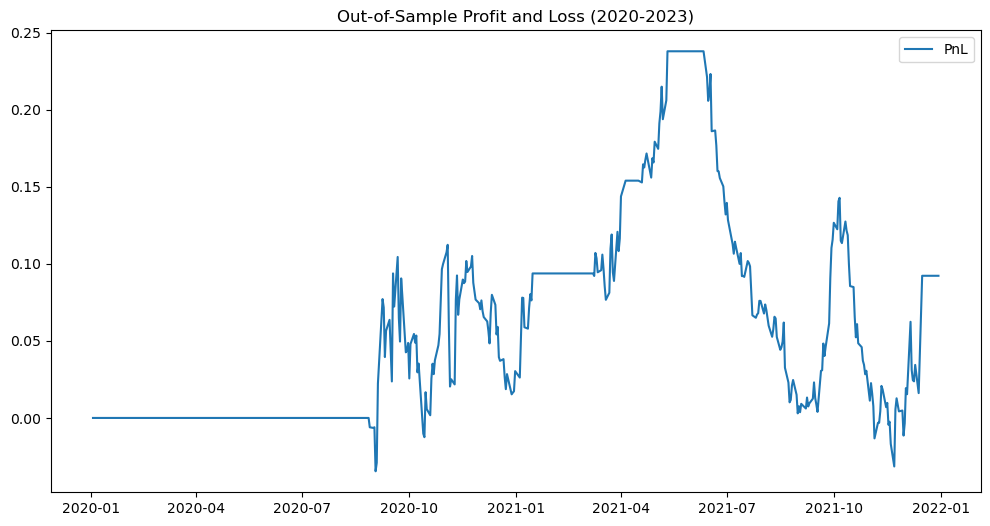

Out-of-Sample Sharpe Ratio: 0.24708234726129527
Out-of-Sample CAGR: 4.53%
Out-of-Sample Maximum Drawdown: -21.77%
Out-of-Sample Calmar Ratio: 0.21
Out-of-Sample Sortino Ratio: 0.30
Out-of-Sample Daily Sharpe Ratio: 0.02
Out-of-Sample Total Returns: 9.23%


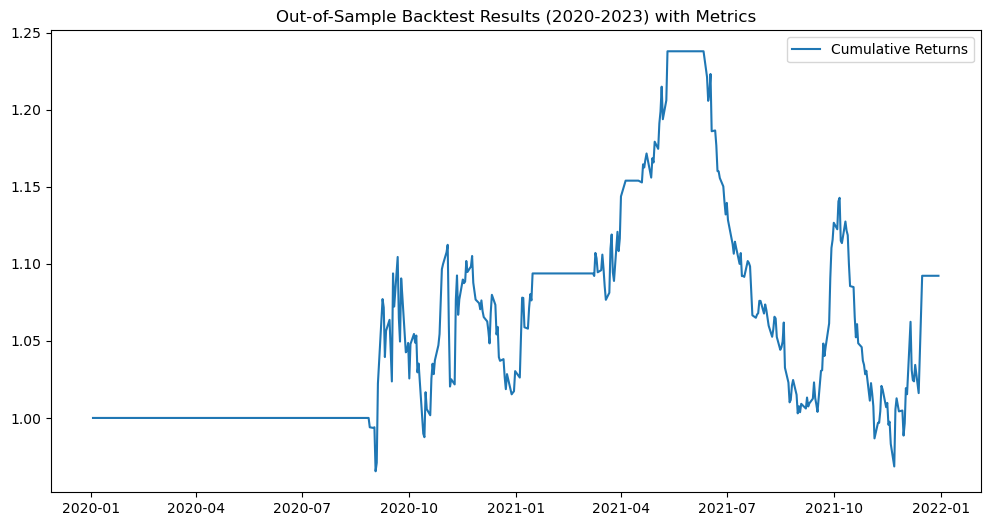

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import yfinance as yf
from math import sqrt

# Download stock price data for training (2018-2019) and testing (2020-2021)
tickers = ["MSFT", "ADBE"]
data = yf.download(tickers, start="2018-03-01", end="2021-12-31")['Open']

# Define Kalman Filter Average
def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(x.values)
    return pd.Series(state_means.flatten(), index=x.index)

# Define Kalman Filter Regression
def KalmanFilterRegression(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    state_means, _ = kf.filter(y.values)
    return state_means

# Define Half-Life Function
def half_life(series):
    lagged = series.shift(1).dropna()
    delta = series.diff().dropna()
    beta = np.polyfit(lagged, delta, 1)[0]
    halflife = -np.log(2) / beta
    return int(max(halflife, 1))

# Define Backtest Function
def backtest(s1, s2, x, y):
    df1 = pd.DataFrame({'y': y, 'x': x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1['hr'] = -state_means[:, 0]
    df1['spread'] = df1.y - (df1.x * df1.hr)
    
    halflife = half_life(df1['spread'])
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread - meanSpread) / stdSpread
    
    entryZscore = 2
    exitZscore = 0
    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > -exitZscore) & (df1.zScore.shift(1) < -exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'], 'num units long'] = 1
    df1.loc[df1['long exit'], 'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'], 'num units short'] = -1
    df1.loc[df1['short exit'], 'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum() + 1
    df1['pnl'] = df1['cum rets'] - 1  # PnL calculation
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1, sharpe

# Split the data into training (2018-2019) and test (2020-2021) sets
train_data = data.loc["2018-03-01":"2019-12-31"]
test_data = data.loc["2020-01-01":"2021-12-31"]

# Perform Backtest on Training Data
train_df, train_sharpe_ratio = backtest('MSFT', 'ADBE', train_data['MSFT'], train_data['ADBE'])

# Perform Backtest on Test Data (Out-of-Sample)
test_df, test_sharpe_ratio = backtest('MSFT', 'ADBE', test_data['MSFT'], test_data['ADBE'])

# Calculate Metrics for Test Data
start_date = test_df.index[0]
end_date = test_df.index[-1]
years = (end_date - start_date).days / 365.25

# CAGR for Test Data
cagr = (test_df['cum rets'].iloc[-1] ** (1 / years)) - 1

# Maximum Drawdown for Test Data
rolling_max = test_df['cum rets'].cummax()
drawdown = test_df['cum rets'] / rolling_max - 1
max_drawdown = drawdown.min()

# Calmar Ratio for Test Data
calmar_ratio = -cagr / max_drawdown if max_drawdown < 0 else 0.0

# Sortino Ratio for Test Data
downside_std = test_df.loc[test_df['port rets'] < 0, 'port rets'].std()
sortino_ratio = (test_df['port rets'].mean() / downside_std) * sqrt(252)

# Daily Sharpe Ratio for Test Data
daily_sharpe = test_df['port rets'].mean() / test_df['port rets'].std()

# Display Metrics for Test Data
print(f"Out-of-Sample Sharpe Ratio: {test_sharpe_ratio}")
print(f"Out-of-Sample CAGR: {cagr:.2%}")
print(f"Out-of-Sample Maximum Drawdown: {max_drawdown:.2%}")
print(f"Out-of-Sample Calmar Ratio: {calmar_ratio:.2f}")
print(f"Out-of-Sample Sortino Ratio: {sortino_ratio:.2f}")
print(f"Out-of-Sample Daily Sharpe Ratio: {daily_sharpe:.2f}")
print(f"Out-of-Sample PnL: {test_df['pnl'].iloc[-1]:.2f}")  # Display final PnL

# Plot Results for Test Data
plt.figure(figsize=(12, 6))
plt.plot(test_df['cum rets'], label='Cumulative Returns')
plt.title("Out-of-Sample Backtest Results (2020-2023) with Metrics")
plt.legend()
plt.show()

# Plot PnL for Test Data
plt.figure(figsize=(12, 6))
plt.plot(test_df['pnl'], label='PnL')
plt.title("Out-of-Sample Profit and Loss (2020-2023)")
plt.legend()
plt.show()

# Calculate Total Returns for Test Data
total_returns = test_df['cum rets'].iloc[-1] - 1

# Display Metrics for Test Data including Total Returns
print(f"Out-of-Sample Sharpe Ratio: {test_sharpe_ratio}")
print(f"Out-of-Sample CAGR: {cagr:.2%}")
print(f"Out-of-Sample Maximum Drawdown: {max_drawdown:.2%}")
print(f"Out-of-Sample Calmar Ratio: {calmar_ratio:.2f}")
print(f"Out-of-Sample Sortino Ratio: {sortino_ratio:.2f}")
print(f"Out-of-Sample Daily Sharpe Ratio: {daily_sharpe:.2f}")
print(f"Out-of-Sample Total Returns: {total_returns:.2%}")

# Plot Results for Test Data
plt.figure(figsize=(12, 6))
plt.plot(test_df['cum rets'], label='Cumulative Returns')
plt.title("Out-of-Sample Backtest Results (2020-2023) with Metrics")
plt.legend()
plt.show()

